<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik -q

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge,LogisticRegression

from sklearn.tree import  DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
#import my_function as fc
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


plt.rcParams["figure.figsize"] = (20,5)

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

In [4]:
data = pd.read_csv('/datasets/taxi.csv')

In [5]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
# изменим тип данных даты и сделаем дату индексом
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.isna().sum()

num_orders    0
dtype: int64

Пропусков нет.

In [10]:
#  ресемплирование по одному часу
data.sort_index(inplace=True)
data =data.resample("1H").sum()

**Вывод**
- Загрузили данные.
- Сделали дату индексом таблицы. В таблице данные с 1 марта 2018 по 31 августа 2018.
- Пропусков нет.
- Провели ресемплирование по одному часу.

## Анализ

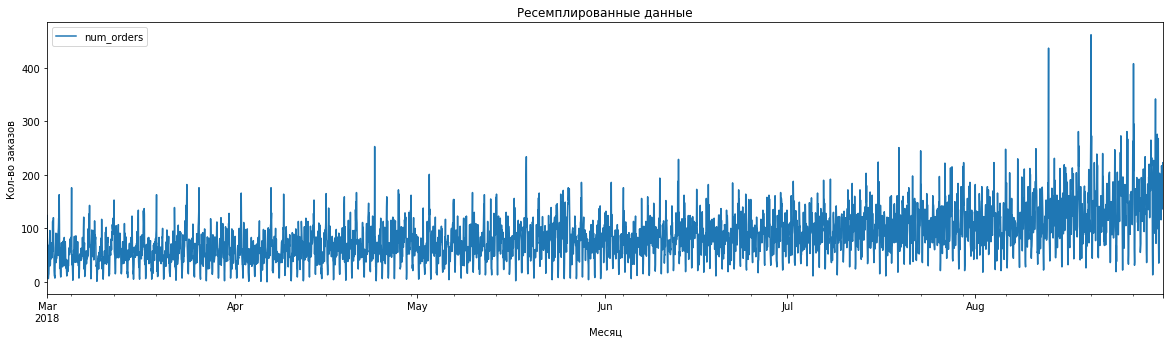

In [11]:
# данные за весь период
data.plot();
plt.title('Ресемплированные данные')
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
plt.show()

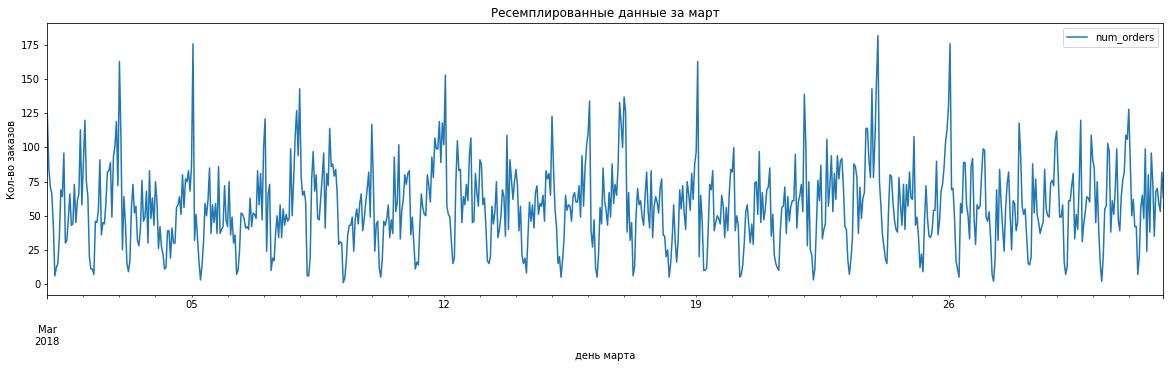

In [12]:
# данные за март
data['2018-03-01':'2018-03-31'].plot();
plt.title('Ресемплированные данные за март')
plt.xlabel('день марта')
plt.ylabel('Кол-во заказов')
plt.show()

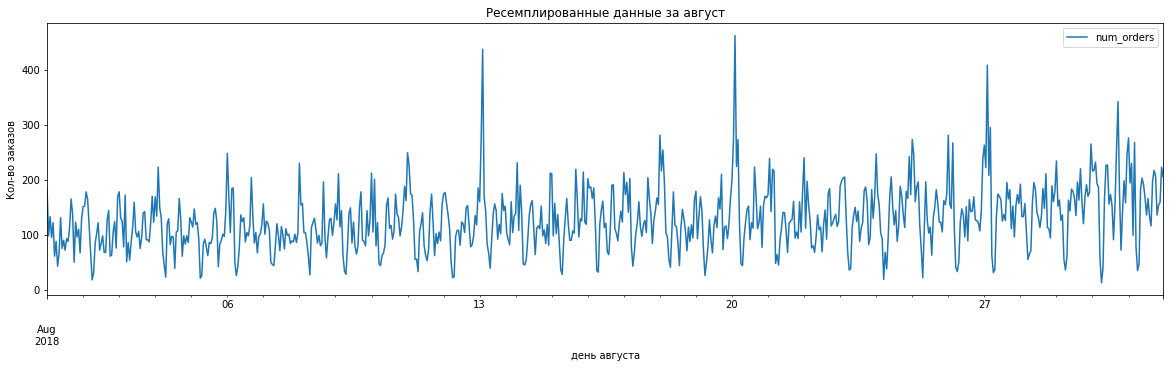

In [13]:
# данные за август
data['2018-08-01':].plot();
plt.title('Ресемплированные данные за август')
plt.xlabel('день августа')
plt.ylabel('Кол-во заказов')
plt.show()

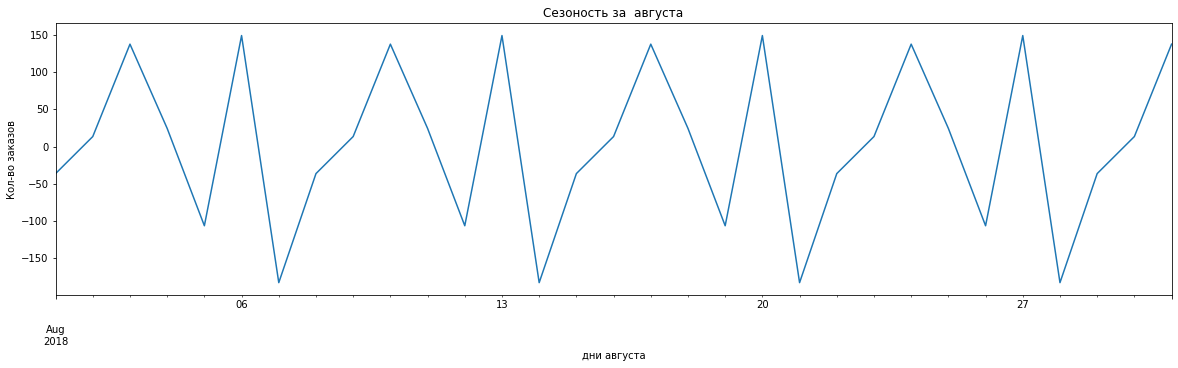

In [14]:
# сезоность за  август
decomposed = seasonal_decompose(data)
decomposed_day = seasonal_decompose(data.resample('1D').sum())
decomposed_day.seasonal['2018-08-01':'2018-08-31'].plot();
plt.title('Сезоность за  августа')
plt.xlabel('дни августа')
plt.ylabel('Кол-во заказов')
plt.show()

Большинство заказов приходится на понедельник и пятницу-субботу.

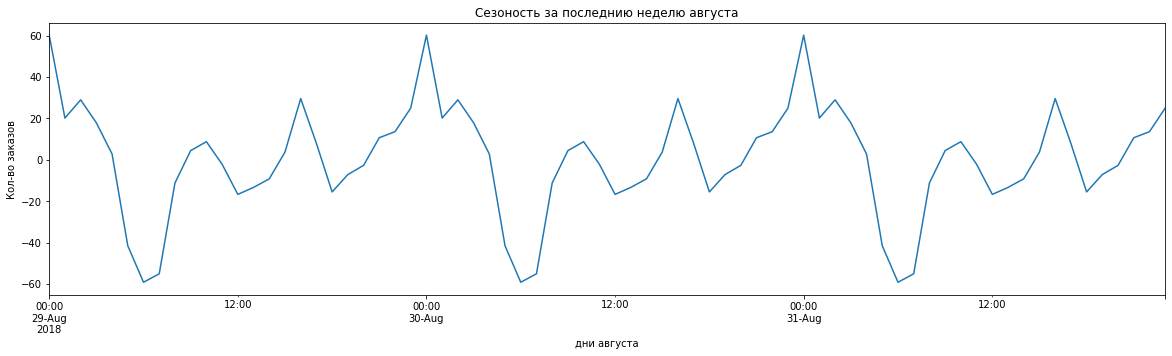

In [15]:
# сезоность за последние три дня августа
decomposed.seasonal['2018-08-29':'2018-08-31'].plot();
plt.title('Сезоность за последнию неделю августа')
plt.xlabel('дни августа')
plt.ylabel('Кол-во заказов')
plt.show()

наблюдаем минимум заказов в 6-7 часов утра.

максимум заказов в полуночь и около 2 часов дня.

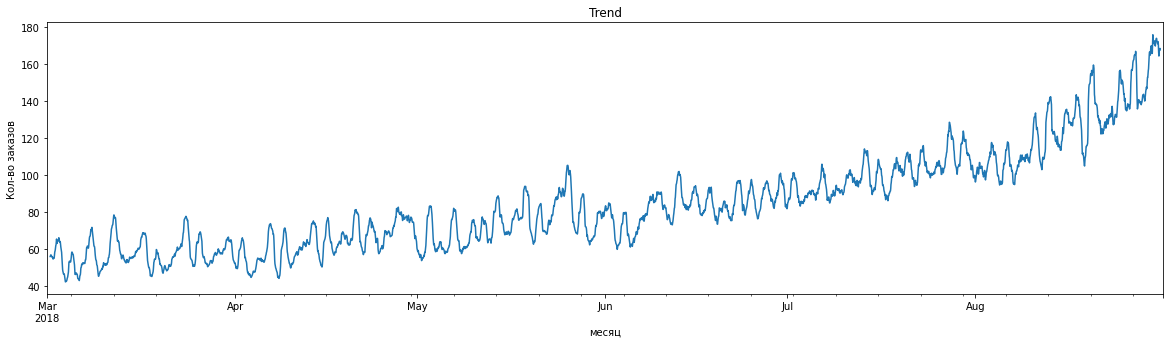

In [16]:
# тренд за весь период
plt.subplot()
decomposed.trend.plot(ax=plt.gca());
plt.title('Trend');
plt.xlabel('месяц')
plt.ylabel('Кол-во заказов')
plt.show()

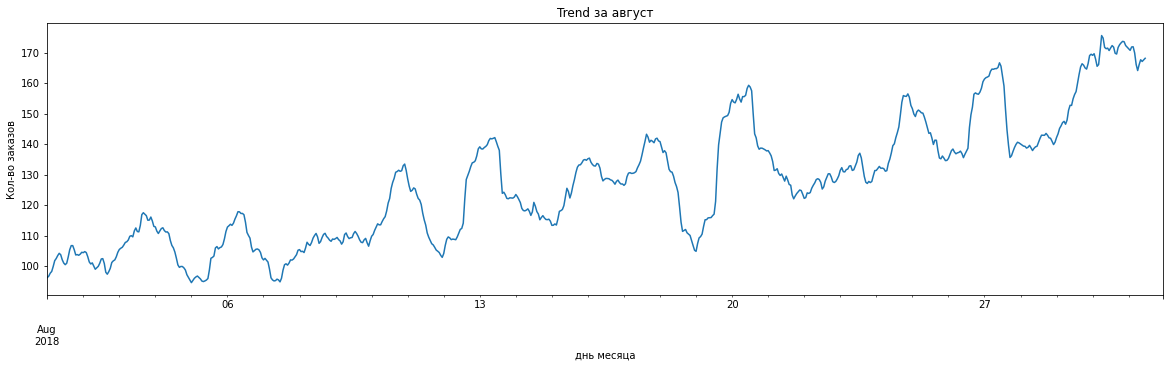

In [17]:
# тренд за август
plt.subplot()
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca());
plt.title('Trend за август');
plt.xlabel('днь месяца')
plt.ylabel('Кол-во заказов')
plt.show()

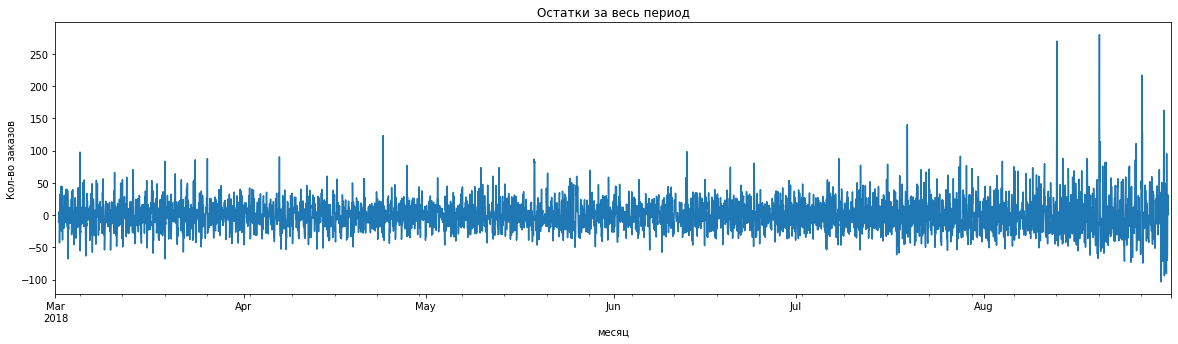

In [18]:
# остатки за весь период
plt.subplot()
decomposed.resid.plot(ax=plt.gca());
plt.title('Остатки за весь период');
plt.xlabel('месяц')
plt.ylabel('Кол-во заказов')
plt.show()

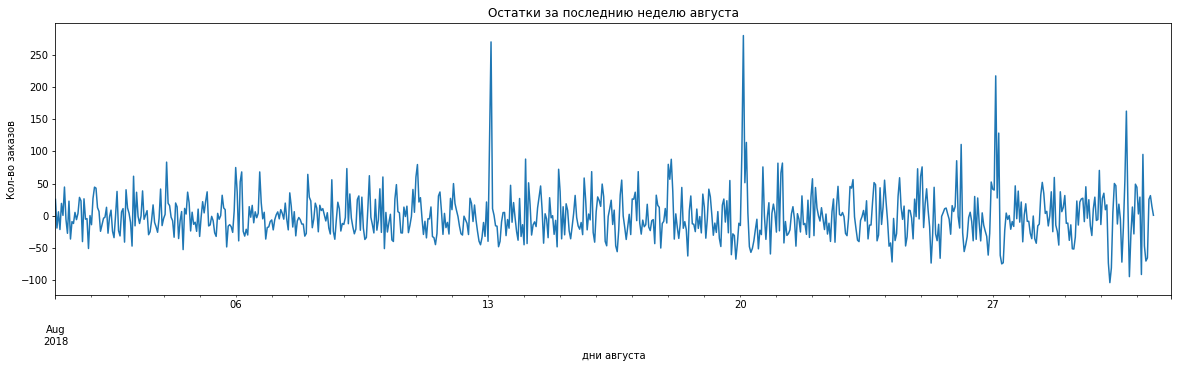

In [19]:
# остатки за последнию неделю августа
plt.subplot()
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca());
plt.title('Остатки за последнию неделю августа');
plt.xlabel('дни августа')
plt.ylabel('Кол-во заказов')
plt.show()

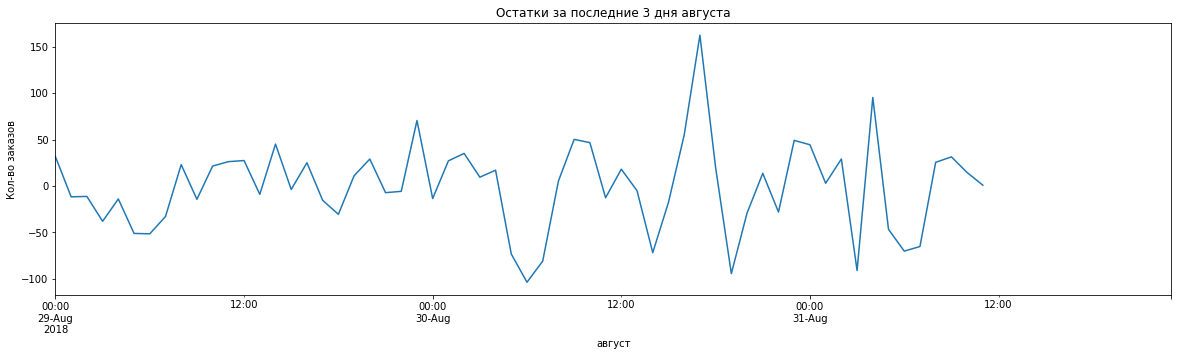

In [20]:
# Остатки за последние 3 дня августа
plt.subplot()
decomposed.resid['2018-08-29':'2018-08-31'].plot(ax=plt.gca());
plt.title('Остатки за последние 3 дня августа');
plt.xlabel('август')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод**
- Тренд  растет, т.к. кол-во заказов и пользователей растет.
- Видно что в количество заказов меняется в течении суток.
- Количество заказов имеет так же недельную сезоность. Количество заказов имеет максимум в понедельник и пятницу-субботу.
- Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени.

## Обучение

In [22]:
max_lag = 168
rolling_mean_size = 24
def make_features(data, column):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()
    return data

In [24]:
make_features(data, 'num_orders')
data =data.dropna()
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,8,3,0,94.0,127.0,108.0,76.0,50.0,99.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,8,3,1,143.0,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,8,3,2,78.0,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,8,3,4,68.0,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


In [25]:
X= data.drop(['num_orders'], axis=1)
y= data['num_orders']
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False, test_size=0.1, random_state = RANDOM_STATE)

In [26]:
col_num = list(X_train.select_dtypes(exclude='object').columns)
preprocessor = ColumnTransformer(
    [
    ('num', StandardScaler(), col_num)
    ], 
    remainder='passthrough') 

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

### LGBMRegressor

In [28]:
pipe_lgbm = Pipeline(
    [('preprocessor', preprocessor),
    ('models', LGBMRegressor(seed=RANDOM_STATE))])

param_grid = {
      'models__learning_rate': [0.3, 0.03],
      'models__n_estimators': [100, 150, 500],
      'models__max_depth': [4, 6, 10],
      'models__colsample_bytree': [0.7, 0.8, 0.9]
      }

In [29]:
%%time
model = RandomizedSearchCV(
    pipe_lgbm, 
    param_grid,
    cv=tscv, 
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error',
    error_score='raise')
model.fit(X_train, y_train)

CPU times: user 2min 35s, sys: 687 ms, total: 2min 36s
Wall time: 2min 39s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['day',
                                                                                'dayofweek',
                                                                                'hour',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                '...
                                                                                'lag_17',
                                                                                'lag_18',
                                                                                'lag_19',
                                                                                'lag_20',
                                                                                'lag_21',
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25',
                                                                                'lag_26',
                                                                                'lag_27', ...])])),
                                             ('models',
                                              LGBMRegressor(seed=42))]),
                   n_jobs=-1,
                   param_distributions={'models__colsample_bytree': [0.7, 0.8,
                                                                     0.9],
                                        'models__learning_rate': [0.3, 0.03],
                                        'models__max_depth': [4, 6, 10],
                                        'models__n_estimators': [100, 150,
                                                                 500]},
                   scoring='neg_root_mean_squared_error')

In [30]:

model_lgbmr= model.best_estimator_
model_lgbmr.fit(X_train, y_train)
val_pred_lgbmr = model_lgbmr.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:', round(mean_squared_error(y_train,val_pred_lgbmr, squared=False)))

Метрика RMSE на тренировочной выборке: 10


RMSE-16

### CatBoostRegressor

In [31]:
model_cat = CatBoostRegressor(loss_function='RMSE',silent=True, random_seed=RANDOM_STATE)

param_cat = {
      'learning_rate': [0.3, 0.03],
      'iterations': [100, 150],
      'depth': [6, 8,10]
      }

In [32]:
%%time
model = RandomizedSearchCV(
    model_cat, 
    param_cat,
    cv=tscv, 
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error',
    error_score='raise')
model.fit(X_train, y_train)

CPU times: user 11min 34s, sys: 2.64 s, total: 11min 36s
Wall time: 12min 16s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f01ccafdc40>,
                   n_jobs=-1,
                   param_distributions={'depth': [6, 8, 10],
                                        'iterations': [100, 150],
                                        'learning_rate': [0.3, 0.03]},
                   scoring='neg_root_mean_squared_error')

In [33]:
model_cat= model.best_estimator_
model_cat.fit(X_train, y_train)
val_pred_cat = model_cat.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_train,val_pred_cat, squared=False)))

Метрика RMSE на тренировочной выборке: 20


RMSE 14

### DecisionTreeRegressor

In [34]:
param_grid_dtc =[{
        'models__max_depth': range(7,10),
        'models__min_samples_leaf': range(1,4),
        'models__max_features': range(3,8),
        'models__min_samples_split': range(3,7)
}]

pipe_dtc = Pipeline(
    [('preprocessor', preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

In [35]:
random_tree = RandomizedSearchCV(
    pipe_dtc, 
    param_grid_dtc, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    n_jobs=-1
)

random_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['day',
                                                                                'dayofweek',
                                                                                'hour',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                '...
                                                                                'lag_19',
                                                                                'lag_20',
                                                                                'lag_21',
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25',
                                                                                'lag_26',
                                                                                'lag_27', ...])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models__max_depth': range(7, 10),
                                         'models__max_features': range(3, 8),
                                         'models__min_samples_leaf': range(1, 4),
                                         'models__min_samples_split': range(3, 7)}],
                   scoring='neg_root_mean_squared_error')

In [36]:
model_dtr = random_tree.best_estimator_
model_dtr.fit(X_train, y_train)

val_pred_dtr = model_dtr.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_train,val_pred_dtr, squared=False)))

Метрика RMSE на тренировочной выборке: 19


RMSE=23

### LinearRegression

In [37]:
param_grid_lr = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [LinearRegression()]
    }
    ]

In [38]:


pipe_lr = Pipeline(
    [('preprocessor', preprocessor),
    ('models', LinearRegression())])

In [39]:
randomized_search_lr = RandomizedSearchCV(
    pipe_lr, 
    param_grid_lr, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    n_jobs=-1
)

randomized_search_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['day',
                                                                                'dayofweek',
                                                                                'hour',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                'lag_12',
                                                                                'lag_13',
                                                                                'lag_14',
                                                                                'lag_15',
                                                                                'lag_16',
                                                                                'lag_17',
                                                                                'lag_18',
                                                                                'lag_19',
                                                                                'lag_20',
                                                                                'lag_21',
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25',
                                                                                'lag_26',
                                                                                'lag_27', ...])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()]}],
                   scoring='neg_root_mean_squared_error')

In [40]:
model_lr = randomized_search_lr.best_estimator_
model_lr.fit(X_train, y_train)


val_pred_dtr = model_lr.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_train,val_pred_dtr, squared=False)))


Метрика RMSE на тренировочной выборке: 20


1. Создали новые признаки.
2. создали пай планы.
3. Провели обучение нескольких моделей.

- Лучшой моделью оказалась CatBoostRegressor с значением RMSE 14


Из всех моделей мы возьмём LGBMRegressor так как у нее лучший результат RMSE.


## Тестирование

In [41]:
# Проверка на адекватность
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print('RMSE =',round( mean_squared_error(y_test,pred_previous, squared=False)))

RMSE = 59


In [43]:
# предсказание модели на тренировочной выборке
val_pred_cat = model_lgbmr.predict(X_test)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_test,val_pred_cat, squared=False)))

Метрика RMSE на тренировочной выборке: 36


Тест на адекватность пройдена, условие по 'RMSE <48' выполнена.

RMSE на тренировочной выборке: 40

## Вывод

- Были загружены и исследованы данные сервиса Чётенькое такси» о заказах такси с 1 марта 2018 по 31 августа 2018.
- Было проведено ресемплирование данных по одному часу.
- Были созданы дополнительные признаки.

На данных были обучены несколько моделей:
1. LGBMRegressor
- RMSE 16.
2. CatBoostRegressor
- RMSE 14.
3. DecisionTreeRegressor
- RMSE 21.
4. LinearRegression
- RMSE 23.

После анализа моделей была выбрана модель CatBoostRegressor.
- Проверку на адекватность пройдена.
- У модели лучшая метрика RMSE.
- RMSE тестовых данных составляет 40.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48